In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

import PIL.Image as Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading the Dataset

In [2]:
train_csv = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
train_csv.tail()

,image_id,label,image_width,image_height,is_tma
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False
537,65533,HGSC,45190,33980,False


In [3]:
train_csv[["image_width", "image_height"]].describe()

,image_width,image_height
count,538.000000,538.000000
mean,48859.533457,29729.460967
std,20040.989927,10762.899796
min,2964.000000,2964.000000
25%,34509.000000,22089.500000
50%,48160.000000,29732.000000
75%,64143.750000,37880.750000
max,105763.000000,50155.000000


In [4]:
path_folder = "/kaggle/input/UBC-OCEAN/train_images"
img_files = [os.path.join(path_folder, 
                          f"{str(f[1][0])}_thumbnail.png") for f in train_csv.iterrows()]

train_csv['path'] = pd.Series(img_files).astype(str)
train_csv.tail()

,image_id,label,image_width,image_height,is_tma,path
533,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_images/65022_thu...
534,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_images/65094_thu...
535,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_images/65300_thu...
536,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_images/65371_thu...
537,65533,HGSC,45190,33980,False,/kaggle/input/UBC-OCEAN/train_images/65533_thu...


In [5]:
istma_false = train_csv[train_csv["is_tma"]==False]
print(len(istma_false))
istma_false.tail()

513


,image_id,label,image_width,image_height,is_tma,path
533,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_images/65022_thu...
534,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_images/65094_thu...
535,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_images/65300_thu...
536,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_images/65371_thu...
537,65533,HGSC,45190,33980,False,/kaggle/input/UBC-OCEAN/train_images/65533_thu...


# Preprocessing

## Cropping the Images

### Example of a cropped image (e.g crop (500,500))

In [6]:
def empty_image(images):
    return np.sum(images) < 100 # threshold

(2523, 3000)
27


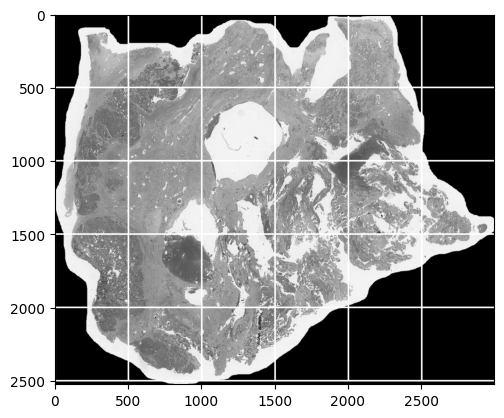

In [7]:
# Sample
ex = "/kaggle/input/UBC-OCEAN/train_thumbnails/4_thumbnail.png"
img = Image.open(ex)
gray = img.convert('L')
gray1 = np.array(gray) # for plotting rectangle

heigth, width = np.array(gray1).shape # height <- shape[0], width <- shape[1]

list_img = []
patch_size = (500,500)
for y in range(0, heigth, patch_size[0]):
    for x in range(0, width, patch_size[1]):
        
        # When cropping an image according to patch_size, 
        # it is possible that the cropped image is less than the size specified in 
        # patch_size. So the crop results are eliminated
        if y+patch_size[1] <= heigth:
            if x+patch_size[0] <= width:
                cv.rectangle(gray1, (x,y), (x+patch_size[0], y+patch_size[1]), 
                              (255, 0, 0), thickness=10)
                
                # Crop the Image
                crop_img = gray.crop((x,y, x+patch_size[0], y+patch_size[1]))
                crop_img = np.array(crop_img)
                
                if empty_image(crop_img):
                    pass
                else:
                    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
                    clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2, 2))
                    clahe_img = clahe.apply(crop_img)
                    
                    list_img.append(clahe_img)
    
#list_img = np.array(list_img)
print(gray1.shape)
print(len(list_img))
plt.imshow(gray1, cmap='gray')

plt.show()

27


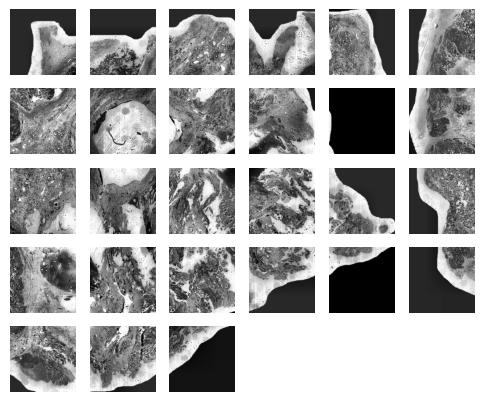

In [8]:
print(len(list_img))
plt.figure(figsize=(6,6))
for i in range(len(list_img)):
    try:
        plt.subplot(6,6,i+1)
        plt.imshow(list_img[i], cmap='gray')
        plt.axis('off')
    except:pass

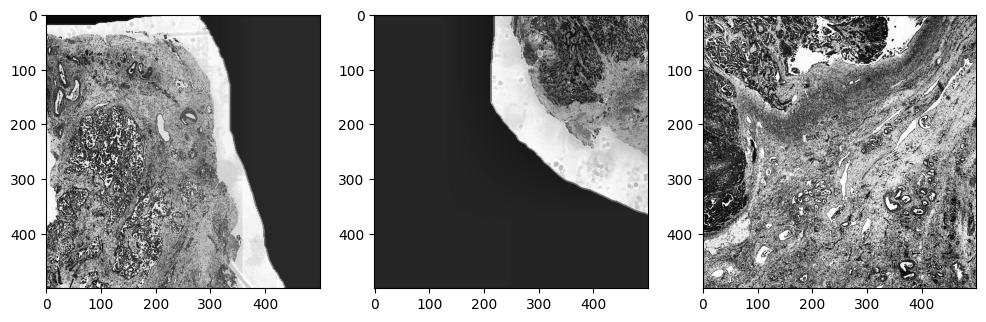

In [9]:
# Sample
random_n = np.random.randint(0,len(list_img),3)

fig, ax = plt.subplots(1,3, figsize=(12, 8))
j=0
for i in random_n:
    ax[j].imshow(list_img[i], cmap='gray')
    j+=1

plt.show()

After cropping, if you notice there are several images that are black (there are no objects in them), so we will eliminate these images by counting the total number of pixels (np.sum(image)).

if (np.sum(image) = 0) then the image has no object and must be eliminated

### Let's Cropping all the Images

In [10]:
def crop_img(path_img, size):
    # Read Img
    img = Image.open(path_img)
    gray = img.convert('L')
    heigth, width = np.array(gray).shape # height <- shape[0], width <- shape[1]

    list_img = []
    patch_size = (size, size)
    for y in range(0, heigth, patch_size[0]):
        for x in range(0, width, patch_size[1]):

            # When cropping an image according to patch_size, 
            # it is possible that the cropped image is less than the size specified in 
            # patch_size. So the crop results are eliminated
            if y+patch_size[1] <= heigth:
                if x+patch_size[0] <= width:
                    # Crop the Image
                    crop_img = gray.crop((x,y, x+patch_size[0], y+patch_size[1]))
                    crop_img = np.array(crop_img) #/ 255.0  # 0 ~ 1사이 숫자로 변환
                    
                    if empty_image(crop_img):
                        pass
                    else:
                        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
                        #clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(2, 2))
                        #clahe_img = clahe.apply(crop_img)

                        list_img.append(crop_img)
                    
    return list_img

In [11]:
def preprocessing_img(dataframe, path):
    classes = []
    images = []
    for data in dataframe.iterrows():
        img_path = os.path.join(path,f"{str(data[1][0])}_thumbnail.png")
        temp_crop_img = crop_img(img_path, 224)
        # Because the image has been converted to grayscale (channel=1) 
        # it is necessary to change from (none,none,1) -> (none,none,3) by 
        # duplicating the first channel on the second and third channels. 
        # How to make source data acceptable to Transfer Learning.
        for lol in temp_crop_img:
            w,h = lol.shape
            rgb_img = np.zeros((w,h,3), dtype=np.uint8)
            rgb_img[:,:,0] = lol
            rgb_img[:,:,1] = lol
            rgb_img[:,:,2] = lol

            images.append(rgb_img)
            classes.append(data[1][1])
        
    return images, classes

In [12]:
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
images, classes = preprocessing_img(istma_false, path)

images = np.array(images)
print(images.shape)
print(len(classes))

(45052, 224, 224, 3)
45052


## Label Encoded

In [13]:
# Encode classes
le = LabelEncoder()
label = le.fit_transform(classes)

label_list = list(le.classes_)
print(len(label))
label_list

45052


['CC', 'EC', 'HGSC', 'LGSC', 'MC']

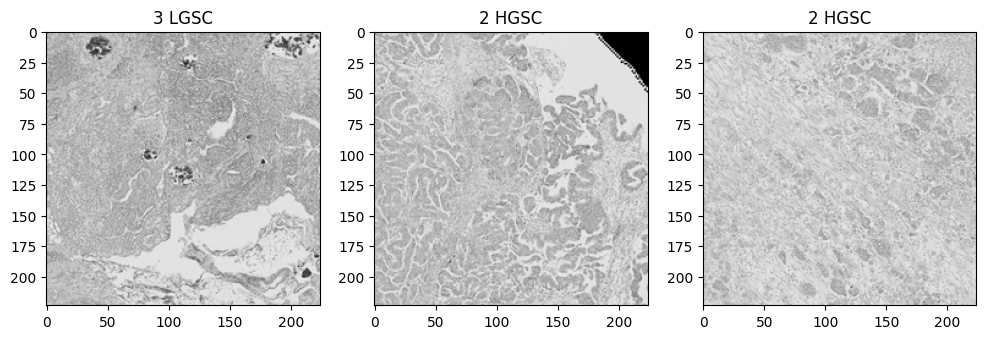

In [14]:
# Sample
random_n = np.random.randint(0,512,3)

fig, ax = plt.subplots(1,3, figsize=(12, 8))
j=0
for i in random_n:
    ax[j].imshow(images[i], cmap='gray'), ax[j].set_title(str(label[i])+" "+classes[i])
    j+=1

plt.show()

# Modelling

In [15]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = True

x = tf.keras.layers.MaxPooling2D()(base_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
#model.summary()

16705208/16705208 [==============================] - 1s 0us/step


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics= ["accuracy"]
)

In [17]:
model_callback = EarlyStopping(
    monitor = 'val_loss', mode = 'min',
    patience = 3,
    restore_best_weights=True
)


In [18]:
history = model.fit(
    images, label,
    batch_size = 32,
    validation_split = 0.3,
    epochs = 100,
    callbacks = [model_callback]
)

Epoch 1/100


2023-12-02 06:15:32.213229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


986/986 [==============================] - 273s 226ms/step - loss: 1.2277 - accuracy: 0.5294 - val_loss: 1.4496 - val_accuracy: 0.5220
Epoch 2/100
986/986 [==============================] - 216s 219ms/step - loss: 0.9564 - accuracy: 0.6519 - val_loss: 1.1186 - val_accuracy: 0.5788
Epoch 3/100
986/986 [==============================] - 216s 220ms/step - loss: 0.8380 - accuracy: 0.6961 - val_loss: 1.3857 - val_accuracy: 0.5403
Epoch 4/100
986/986 [==============================] - 216s 219ms/step - loss: 0.7657 - accuracy: 0.7240 - val_loss: 1.2292 - val_accuracy: 0.5758
Epoch 5/100
986/986 [==============================] - 216s 219ms/step - loss: 0.7006 - accuracy: 0.7460 - val_loss: 1.2992 - val_accuracy: 0.5400


In [19]:
os.mkdir('/kaggle/working/saved_model')

In [20]:
save_path ='/kaggle/working/saved_model'
tf.saved_model.save(model, save_path )